In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

In [2]:
plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)

In [3]:
# Simulation parameters
s = 1.0    # rest length
tf = 2.0  # final time
rA = 1.5   # maximum interaction distance

seed=17

params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': muR*ratio, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 1.95
params_gls = {'mu': mu_gls, 'a': 7.51}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

In [4]:
force_names = ['cubic', 'pw. quad.', 'GLS']
solver_names = ['EF', 'EB']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}
linestyles = {'cubic': '-', 'pw. quad.': '--', 'GLS': '-.'}

In [5]:
models_ef = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), ef.solve_ivp, 1), 
             'cubic': cbmos.CBMModel(ff.Cubic(), ef.solve_ivp, 1),
             'GLS': cbmos.CBMModel(ff.Gls(), ef.solve_ivp, 1)}
models_eb = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), eb.solve_ivp, 1), 
             'cubic': cbmos.CBMModel(ff.Cubic(), eb.solve_ivp, 1),
             'GLS': cbmos.CBMModel(ff.Gls(), eb.solve_ivp, 1)}
model_dicts = {'EF': models_ef, 'EB': models_eb}

In [6]:
# Initial condition
cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [0.3], proliferating=False)]

In [7]:
t_data_ref = np.linspace(0, tf, 10000+1)


In [8]:
len(t_data_ref)

10001

In [9]:
t_data_ref[-1]

2.0

In [10]:
dt = 1e-4
t_data_ref = np.arange(0, tf, dt)
#t_data_ref = np.linspace(0, tf, 10000+1)

#t_data_ref=[0,tf]
ref_sol_dicts = {}
for solver in solver_names:
    models = model_dicts[solver]
    ref_sols = {}
    for force in force_names: 
        #params_solver = {'EF':{'dt': 0.0001}, 'EB': {'dt': 0.0001, 'jacobian': models[force].jacobian}}
        params_solver = {'EF':{'dt': dt}, 'EB': {'dt': dt}}
        history = models[force].simulate(cell_list, t_data_ref, params[force], params_solver[solver], seed=seed)
        ref_sols[force] = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])[:len(t_data_ref)] # THIS IS A HACK!!!
    ref_sol_dicts[solver] = ref_sols

In [11]:
len(ref_sol_dicts['EB'][force])

20000

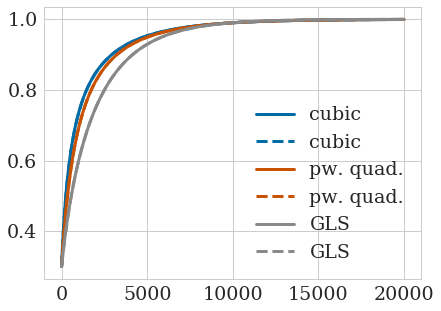

In [12]:
# plot the reference solution
for force in force_names:
    plt.plot(ref_sol_dicts['EF'][force], label=force, color=colors[force])
    plt.plot(ref_sol_dicts['EB'][force], label=force, linestyle='--', color=colors[force])
plt.legend()

In [13]:
dt_values = [0.001*1.25**n for n in range(0, 28)]

In [14]:
sol_dicts = {}

In [15]:
n = 15 
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(tf/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        av_time = 0
        for j in np.arange(n):
            start = time.time()
            history = model_dicts['EF'][force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
            exec_time = time.time() - start
            av_time = av_time + exec_time
        av_time = av_time / n
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        length = min(len(t_data), len(y))
        inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
        ref = np.squeeze(ref_sol_dicts['EF'][force])
        sol[force].append((np.linalg.norm(inter-ref)/np.linalg.norm(ref), av_time))
sol_dicts['EF'] = sol

[2001, 0.001]
[1601, 0.00125]
[1281, 0.0015625]
[1025, 0.001953125]
[820, 0.00244140625]
[656, 0.0030517578125]
[525, 0.003814697265625]
[420, 0.00476837158203125]
[336, 0.0059604644775390625]
[269, 0.007450580596923828]
[215, 0.009313225746154785]
[172, 0.011641532182693481]
[138, 0.014551915228366852]
[110, 0.018189894035458565]
[88, 0.022737367544323206]
[71, 0.028421709430404007]
[57, 0.03552713678800501]
[46, 0.04440892098500626]
[37, 0.05551115123125783]
[29, 0.06938893903907228]
[24, 0.08673617379884035]
[19, 0.10842021724855044]
[15, 0.13552527156068805]
[12, 0.16940658945086007]
[10, 0.21175823681357508]
[8, 0.2646977960169689]
[7, 0.3308722450212111]
[5, 0.41359030627651383]


In [16]:
np.array(sol_dicts['EF']['cubic'])[:,0]

array([5.39440461e-04, 6.90211966e-04, 8.79272818e-04, 1.11653582e-03,
       1.41460467e-03, 1.78958173e-03, 2.26216827e-03, 2.85921152e-03,
       3.61593928e-03, 4.57935050e-03, 5.81360007e-03, 7.40920037e-03,
       9.49974042e-03, 1.22944631e-02, 1.61445898e-02, 2.16802233e-02,
       3.00889797e-02, 4.36951189e-02, 6.73692989e-02, 1.13366282e-01,
       2.31557024e-01, 5.98156497e-01, 9.09415336e-01, 1.29549057e+00,
       1.77216607e+00, 2.35800096e+00, 3.07396313e+00, 3.94251560e+00])

In [17]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force])[:, 0] > 0.01)[0][0]]])

['cubic', 0.018189894035458565]
['pw. quad.', 0.022737367544323206]
['GLS', 0.028421709430404007]


In [18]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force])[:, 0] > 0.1)[0][0]]])

['cubic', 0.06938893903907228]
['pw. quad.', 0.10842021724855044]
['GLS', 0.16940658945086007]


In [19]:
n = 5
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(tf/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        av_time = 0
        for j in np.arange(n):
            start = time.time()
            history = model_dicts['EB'][force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
            exec_time = time.time() - start
            av_time = av_time + exec_time
        av_time = av_time / n
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        length = min(len(t_data), len(y))
        inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
        ref = np.squeeze(ref_sol_dicts['EB'][force])
        sol[force].append((np.linalg.norm(inter-ref)/np.linalg.norm(ref), av_time))
sol_dicts['EB'] = sol

[2001, 0.001]
[1601, 0.00125]
[1281, 0.0015625]
[1025, 0.001953125]
[820, 0.00244140625]
[656, 0.0030517578125]
[525, 0.003814697265625]
[420, 0.00476837158203125]
[336, 0.0059604644775390625]
[269, 0.007450580596923828]
[215, 0.009313225746154785]
[172, 0.011641532182693481]
[138, 0.014551915228366852]
[110, 0.018189894035458565]
[88, 0.022737367544323206]
[71, 0.028421709430404007]
[57, 0.03552713678800501]
[46, 0.04440892098500626]
[37, 0.05551115123125783]
[29, 0.06938893903907228]
[24, 0.08673617379884035]
[19, 0.10842021724855044]
[15, 0.13552527156068805]
[12, 0.16940658945086007]
[10, 0.21175823681357508]
[8, 0.2646977960169689]
[7, 0.3308722450212111]
[5, 0.41359030627651383]


In [20]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EB'][force])[:, 0] > 0.01)[0][0]]])

['cubic', 0.022737367544323206]
['pw. quad.', 0.022737367544323206]
['GLS', 0.028421709430404007]


In [21]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EB'][force])[:, 0] > 0.1)[0][0]]])

['cubic', 0.3308722450212111]
['pw. quad.', 0.3308722450212111]
['GLS', 0.41359030627651383]


In [22]:
dt_values

[0.001,
 0.00125,
 0.0015625,
 0.001953125,
 0.00244140625,
 0.0030517578125,
 0.003814697265625,
 0.00476837158203125,
 0.0059604644775390625,
 0.007450580596923828,
 0.009313225746154785,
 0.011641532182693481,
 0.014551915228366852,
 0.018189894035458565,
 0.022737367544323206,
 0.028421709430404007,
 0.03552713678800501,
 0.04440892098500626,
 0.05551115123125783,
 0.06938893903907228,
 0.08673617379884035,
 0.10842021724855044,
 0.13552527156068805,
 0.16940658945086007,
 0.21175823681357508,
 0.2646977960169689,
 0.3308722450212111,
 0.41359030627651383]

In [23]:
sol_dicts['EF']['GLS']

[(0.0003427255739759546, 0.20290493965148926),
 (0.0004381443295849506, 0.282001002629598),
 (0.0005575558656401683, 0.10752679506937662),
 (0.000707034511215416, 0.09256731669108073),
 (0.0008942186872132709, 0.07461883227030436),
 (0.0011287285941413347, 0.08298133214314779),
 (0.0014227037206075777, 0.04718942642211914),
 (0.0017915014210693036, 0.051376756032307944),
 (0.0022546144516111684, 0.06145760218302409),
 (0.00283689150019123, 0.02819854418436686),
 (0.0035701868611833524, 0.02068333625793457),
 (0.004495644951229272, 0.014617363611857096),
 (0.005666934747018149, 0.012094338734944662),
 (0.007154990647428634, 0.013509496053059896),
 (0.00905520589323428, 0.01359866460164388),
 (0.01149874607259258, 0.007587782541910807),
 (0.014670934428405833, 0.008078622817993163),
 (0.018841791607628073, 0.003699509302775065),
 (0.024416993045418816, 0.006337738037109375),
 (0.03202166561725433, 0.0023569424947102865),
 (0.04263331870621683, 0.002007452646891276),
 (0.05778229877224516

Text(0.5, 1.0, '$\\bf{(b)}$ Backward Euler method')

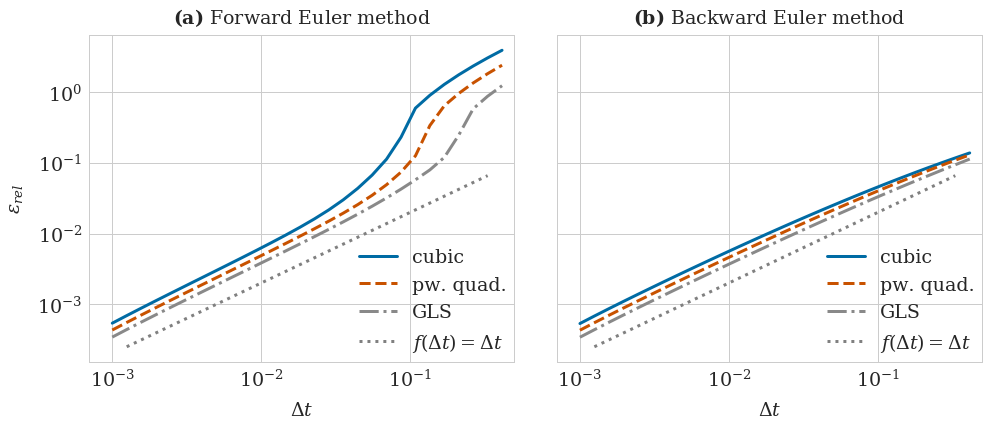

In [24]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6), sharey=True, gridspec_kw={'wspace': 0.1})

# ax1
for force in force_names: 
    ax1.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,0], label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,1], label=force+' y')
ax1.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax1.legend(loc='lower right', borderaxespad=0.)
#plt.legend()
ax1.set(xlabel='$\Delta t$')
ax1.set_title(r'$\bf{(a)}$ Forward Euler method')
ax1.set(ylabel='$\epsilon_{rel}$')
ax1.set_xlim([7*1e-4, 5*1e-1])
#ax1.set_ylim([5*1e-10, 10*1e-0])
#ax1.set_xticklabels([])
#ax1.set_ylim([5*1e-8, 5*1e-0])
#ax1.text(0.0025, 25, 'Forward Euler method', fontsize=22)
#ax1.text(0.0001, 0.000001, 'Relaxation', fontsize=22, rotation='vertical')


#ax2
for force in force_names: 
    ax2.loglog(dt_values, np.array(sol_dicts['EB'][force])[:,0], label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts[current_solver][force])[:,1], label=force+' y')
ax2.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax2.legend(loc='lower right',borderaxespad=0.)
ax2.set(xlabel='$\Delta t$')
ax2.set_xlim([7*1e-4, 5*1e-1])
ax2.set_title(r'$\bf{(b)}$ Backward Euler method')
#ax2.set_xticklabels([])

#ax2.text(0.0025, 25, 'Backward Euler method', fontsize=22)
#plt.savefig('convergence_study_EB.pdf', bbox_inches='tight')

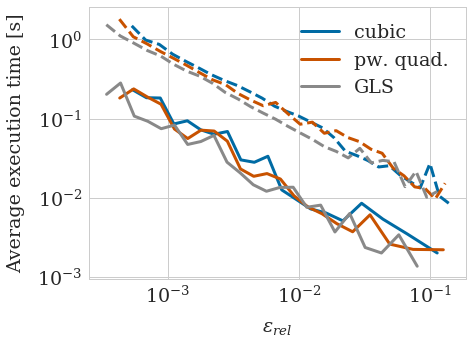

In [25]:
end_index = {'cubic': -8, 'pw. quad.': -6, 'GLS': -5}

for force in force_names:
    plt.loglog(np.array(sol_dicts['EF'][force])[:end_index[force],0], np.array(sol_dicts['EF'][force])[:end_index[force],1], label=force, color=colors[force])
    plt.loglog(np.array(sol_dicts['EB'][force])[:,0], np.array(sol_dicts['EB'][force])[:,1], linestyle='--', color=colors[force])

plt.xlabel('$\epsilon_{rel}$')    
plt.ylabel('Average execution time [s]')
plt.legend()
#plt.savefig('exec_time_EB.pdf', bbox_inches='tight')

Let's pick dt = 0.2 for EB

In [26]:
force = 'GLS'
dt = 0.22
t_data = np.arange(0,1,dt)

In [27]:
%%time
history = models_ef[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)

CPU times: user 1.67 ms, sys: 111 µs, total: 1.78 ms
Wall time: 3.39 ms


In [28]:
history = models_eb[force].simulate(cell_list, t_data, params[force], {'dt': dt, 'jacobian': models_eb[force].jacobian, 'eps': 0.00001}, seed=seed)
y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
length = min(len(t_data), len(y))
inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
ref = np.squeeze(ref_sol_dicts['EB'][force])
error_eb = np.linalg.norm(inter-ref)/np.linalg.norm(ref)

In [29]:
error_eb

0.07511090506080652

In [30]:
%%time
history = models_eb[force].simulate(cell_list, t_data, params[force], {'dt': dt, 'jacobian': models_eb[force].jacobian}, seed=seed)


CPU times: user 9.15 ms, sys: 7.27 ms, total: 16.4 ms
Wall time: 34.7 ms


In [31]:
history = models_eb[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
length = min(len(t_data), len(y))
inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
ref = np.squeeze(ref_sol_dicts['EB'][force])
error_eb_no_jac = np.linalg.norm(inter-ref)/np.linalg.norm(ref)

In [32]:
error_eb_no_jac

0.07511161441234937

In [33]:
%%time
history = models_eb[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)


CPU times: user 1.94 ms, sys: 7.91 ms, total: 9.85 ms
Wall time: 20.3 ms


And dt=0.1 for EF

In [34]:
dt = 0.12
t_data = np.arange(0,1,dt)

In [35]:
history = models_ef[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
length = min(len(t_data), len(y))
inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
ref = np.squeeze(ref_sol_dicts['EF'][force])
error_ef = np.linalg.norm(inter-ref)/np.linalg.norm(ref)

In [36]:
error_ef

0.06676234525666193

In [37]:
%%time
history = models_ef[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)

CPU times: user 2.27 ms, sys: 153 µs, total: 2.43 ms
Wall time: 5.62 ms


In [38]:
y.shape

(9, 1)

In [39]:
y[-1]

array([0.99855683])

ValueError: x and y must have same first dimension, but have shapes (10001,) and (9, 1)

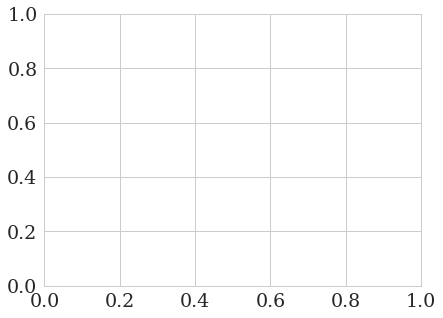

In [40]:
plt.plot(np.cumsum(dt*np.ones(10001)), y)